# Определение локации для скважины

В компании «ГлавРосГосНефть» необходимо определить, где бурить новую нефтяную скважину.

Предоставлены данные о пробах нефти в трех регионах. В каждом регионе исследовано 10 110 месторождений, для которых измерено качество нефти и объем запасов. Задача проекта заключается в разработке модели машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль. Анализ возможной прибыли и рисков осуществляется с помощью техники *Bootstrap*.

### Шаги для выбора локации:

- В выбранном регионе находятся месторождения, для каждого из которых определяются значения признаков.
- Строится модель, оценивающая объем запасов.
- Из всех месторождений выбираются те, которые получили самые высокие оценки. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины.
- Рассчитывается прибыль как суммарная прибыль отобранных месторождений.

### Описание данных

- id — уникальный идентификатор скважины
- f0, f1, f2 — три признака месторождений (важны сами признаки)
- product — объем запасов в скважине (тыс. баррелей)

### Условия задачи:

- Для модели используется только линейная регрессия.
- В каждом регионе исследуется 500 точек, из которых выбираются 200 лучших для разработки.
- Бюджет на разработку скважин в регионе составляет 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода, а доход с каждой единицы продукта составляет 450 тыс. рублей.
- Оставляются только те регионы, где вероятность убытков меньше 2.5%. Далее из них выбирается регион с наибольшей средней прибылью.

## Подготовка окружения

In [12]:
!pip install --upgrade scikit-learn==1.2.2 -q
!pip install --upgrade numpy==1.26.4 -q
!pip install --upgrade seaborn==0.13.0 -q
!pip install --upgrade shap==0.45.0 -q
!pip install --upgrade phik==0.12.4 -q
!pip install --upgrade pandas==2.1.4 -q
!pip install --upgrade scipy==1.12.0 -q
!pip install --upgrade matplotlib==3.8.0 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [13]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState



In [14]:
sns.set_theme()
sns.set_palette('Set2')
RANDOM_STATE = 5
STATE = RandomState(12345)

## Загрузка и подготовка данных

In [15]:
def get_info(data: pd.DataFrame) -> None:
    '''
    Function for printing base information of dataframe
    :param data: dataframe for search
    '''
    print('Info about data:')
    data.info()
    print('\nInfo about missing data:\n', data.isna().sum())
    print('\nInfo about duplicates:\n', data.duplicated().sum())

In [16]:
def count_duplicated(data: pd.DataFrame) -> None:
    duplicated = data.loc[data.duplicated(subset=['id'])]['id'].count()
    print(f'Процент повторяющихся идентификаторов {round(duplicated/data.shape[1] * 100, 3)}%')

In [17]:
if (os.path.exists('/datasets/geo_data_1.csv') and 
    os.path.exists('/datasets/geo_data_1.csv') and 
    os.path.exists('/datasets/geo_data_2.csv')):

    region_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    region_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    region_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

elif (os.path.exists('./datasets/geo_data_0.csv') and 
      os.path.exists('./datasets/geo_data_1.csv') and 
      os.path.exists('./datasets/geo_data_2.csv')):
    
    region_geo_0 = pd.read_csv('./datasets/geo_data_0.csv')
    region_geo_1 = pd.read_csv('./datasets/geo_data_1.csv')
    region_geo_2 = pd.read_csv('./datasets/geo_data_2.csv')

else:
    print('Something went wrong')

Изучим данные, которые мы получили.
### Для начала рассмотрим первый регион

In [18]:
get_info(region_geo_0)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Info about missing data:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Info about duplicates:
 0


In [19]:
region_geo_0.sample(5)

,id,f0,f1,f2,product
17001,CmNRx,0.589938,-0.309241,1.331875,136.905907
5119,9dqPJ,0.412225,1.066530,-4.698450,34.482986
15311,xRaYD,1.971423,0.253909,2.269961,151.664080
27477,qILFi,0.959952,0.184965,2.908647,51.532894
30428,qVThc,0.910977,0.286879,-0.002091,26.339232


In [20]:
region_geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Проверим, есть дубликаты по `id` скважины

In [21]:
region_geo_0.loc[region_geo_0.duplicated(subset=['id'])]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [22]:
count_duplicated(region_geo_0)

Процент повторяющихся идентификаторов 200.0%


Довольно странно, что сущестувуют дубликаты для скважин. Поскольку это уникальный идентификатор скважин, и данные вероятно получены за определенный период, дублирующиеся скважины уберем из датасетов и проверим остальные данные на дублирующиеся скважины.

In [23]:
region_geo_0.drop_duplicates(subset=['id'], inplace=True)

In [24]:
def duplicates_features_product(data: pd.DataFrame) -> None:
    features = data.loc[data.duplicated(subset=['f0', 'f1', 'f2'])].count()
    product = data.loc[data.duplicated(subset=['product'])].count()
    print(f'Duplicated data features: \n{features}\nDuplicated data product:\n{product}')

In [25]:
duplicates_features_product(region_geo_0)

Duplicated data features: 
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Duplicated data product:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Повторяющийхся данных по признакам точек, а также по объему запасов в скважине не обнаружено

### Рассмотрим датасет про второй регион

In [26]:
get_info(region_geo_1)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Info about missing data:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Info about duplicates:
 0


In [27]:
region_geo_1.sample(5)

,id,f0,f1,f2,product
58567,SB73M,1.390099,0.071042,5.002155,137.945408
7781,DJ9Jp,-12.692365,-3.987592,2.994031,84.038886
90844,o4jzs,-8.768813,-8.360652,1.999538,57.085625
35056,UIxvP,-15.444129,-2.555268,1.000488,30.132364
49670,t9nDV,-5.523133,-7.672688,2.998438,84.038886


In [28]:
region_geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [29]:
region_geo_1.loc[region_geo_1.duplicated(subset=['id'])]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [30]:
count_duplicated(region_geo_1)

Процент повторяющихся идентификаторов 80.0%


Во втором регионе также присутствуют дубликаты скважин, их уникальные идентификаторы не повторяются, что вполне логично. Дубликтов меньше, чем в пером регионе и они составляют малую долю от общего количества данных, поэтому их можно также удалить

In [31]:
region_geo_1.drop_duplicates(subset=['id'], inplace=True)

In [32]:
duplicates_features_product(region_geo_1)

Duplicated data features: 
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Duplicated data product:
id         99984
f0         99984
f1         99984
f2         99984
product    99984
dtype: int64


In [33]:
region_geo_1.loc[region_geo_1.duplicated(subset=['product'])]

,id,f0,f1,f2,product
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408
10,7uHUe,11.777049,-5.334084,2.003033,53.906522
13,igmai,6.695604,-0.749449,-0.007630,0.000000
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


Вероятно из-за того, что данные синтезированы, во втором регионе есть дубликаты по запасам в скважине. Эти данные оставим как есть

### Рассмотрим данные для третьего региона

In [34]:
get_info(region_geo_2)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Info about missing data:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Info about duplicates:
 0


In [35]:
region_geo_2.sample(5)

,id,f0,f1,f2,product
64120,Z98h6,3.073050,1.729401,2.563300,186.923754
87550,1pX2b,-0.855153,-2.285856,-0.393036,53.855903
8832,P7Mul,-1.758736,1.142332,2.820531,96.070275
74478,AIzxA,-0.077526,-0.653167,-1.772690,89.914064
52055,oLjAU,-3.657134,1.024838,-5.233848,77.388177


In [36]:
region_geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [37]:
region_geo_2.loc[region_geo_2.duplicated(subset=['id'])]

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


В третьем регионе также пристутствует незначительное количество дубликтов с одинаковым идентификаторам по скважинам. Их доля составляет малую часть, поэтому их можно удалить, чтобы данные оставались "чистыми"

In [38]:
duplicates_features_product(region_geo_2)

Duplicated data features: 
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
Duplicated data product:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


В третьем регионе не обнаружено повторящихся признаков скважин или запасам скважины.

**Вывод**:
- Были проанализированны датасеты с данными. Среди записей таблицы были обнаружены дубликаты по уникальным идентификаторам скважин, были принято решение удалить эти данные. Всего было удалено 18 записей
- В данных второго региона были обнаружены дубликаты в данных по признакам `f1`, `f2`, `f0`, те есть данные повторяются в почти 50 процентов случаев.

### Проведем исследовательский анализ для всех трех регионов

In [39]:
def numerical_plot(df: pd.DataFrame, title: str, features: dict):
    '''
    function for plotting numerical distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики количественных признаков для {title}')
    for feature, feat_ru in features.items():
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        sns.histplot(data=df, x=feature, kde=True, ax=axes[0], bins=round(log((len(df[feature].unique()) + 1))*2, ))
        sns.boxplot(data=df, x=feature, ax=axes[1])
        fig.suptitle(f'Распределение для {feat_ru}')
        for num in range(2):
            axes[num].set_ylabel('Количество')
            axes[num].set_xlabel(feat_ru)

In [40]:
numerical_features = {
    'f0': 'Признак 1',
    'f1': 'Признак 2',
    'f2': 'Признак 3',
    'product': 'объём запасов в скважине'
}

#### Анализ для первого региона

In [41]:
region_geo_0.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


Графики количественных признаков для первого региона


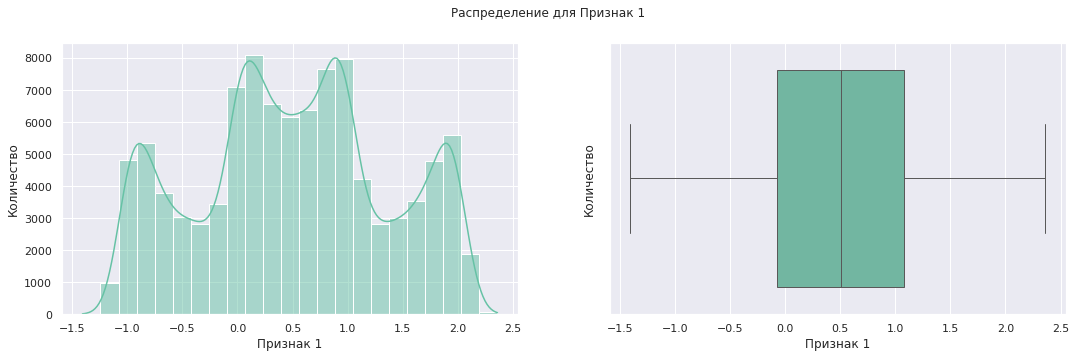

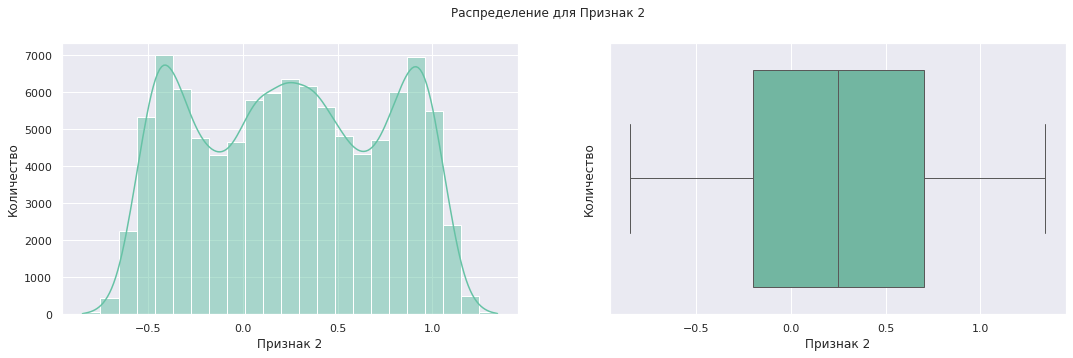

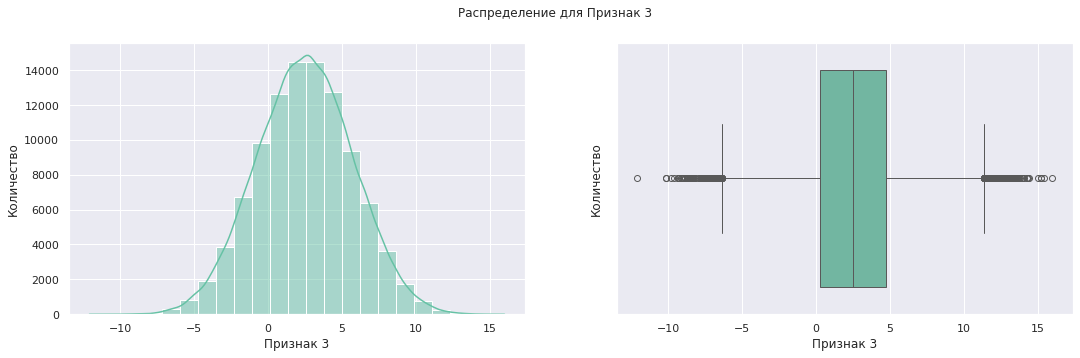

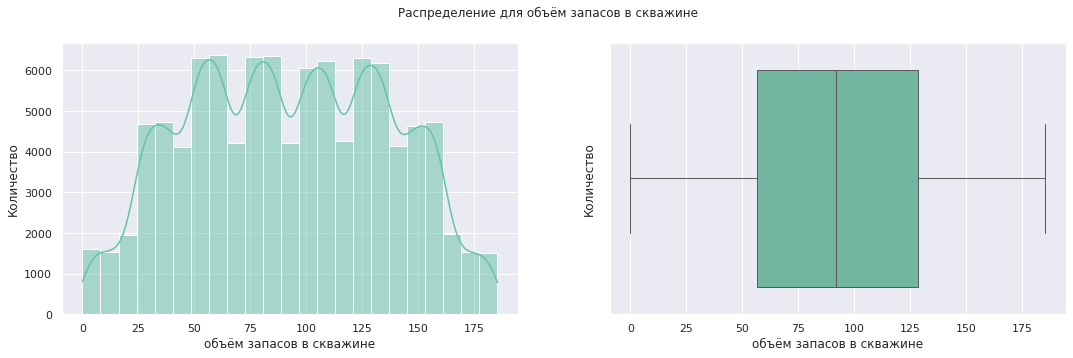

In [42]:
numerical_plot(region_geo_0, 'первого региона', numerical_features)

Данные на графике для второго признака распределены нормально, однако для остальных параметров заметны симметричные максимумы, а для объема запасов нет четкого максимума, наблюдается флуктация

#### Анализ для второго региона

In [43]:
region_geo_1.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Графики количественных признаков для второго региона


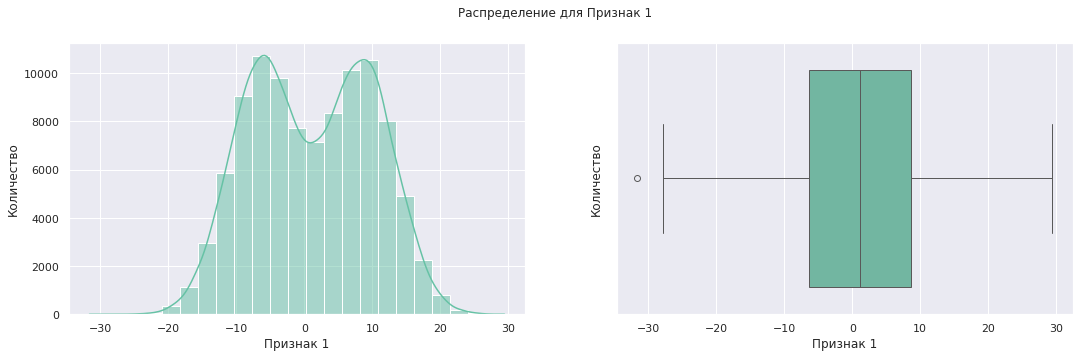

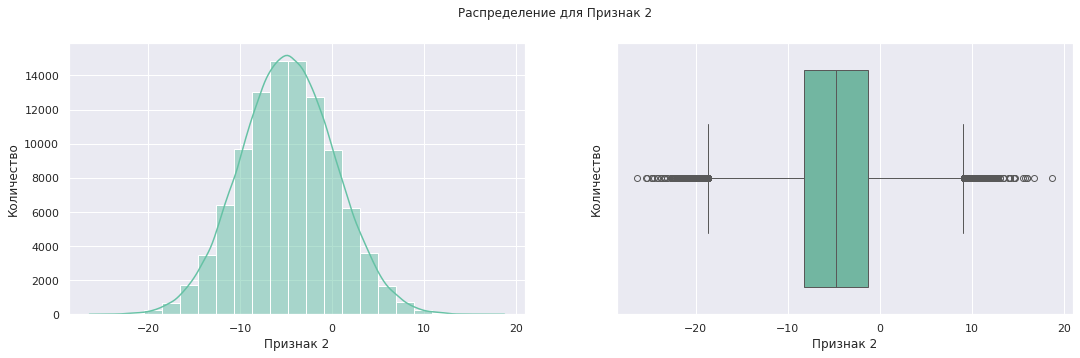

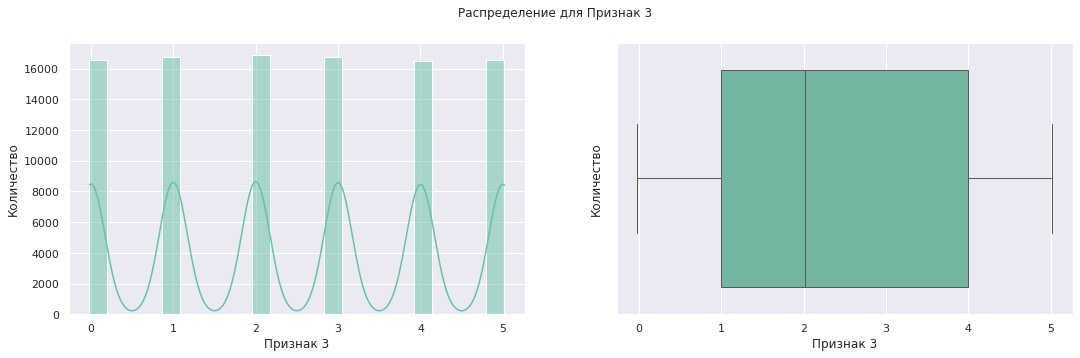

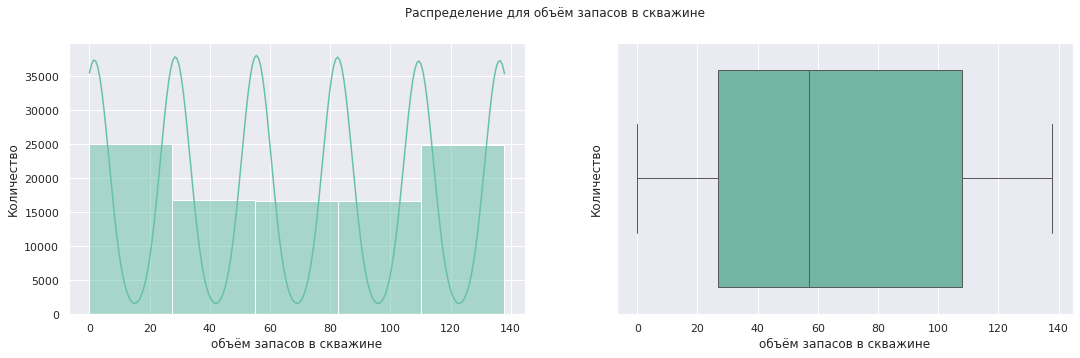

In [44]:
numerical_plot(region_geo_1, 'второго региона', numerical_features)

Для второго региона можно отметить довольно странные распределения для третьего признака и объема запасов в скважине. По сравнению с первым регионом, данные выглядят довольно странно - нет какого-то центрального пика, данные будто размазаны по промежутку для объема запасов в скважине и для третьего признака распределены как будто дискретно.

#### Анализ третьего региона

In [45]:
region_geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Графики количественных признаков для для третьего региона


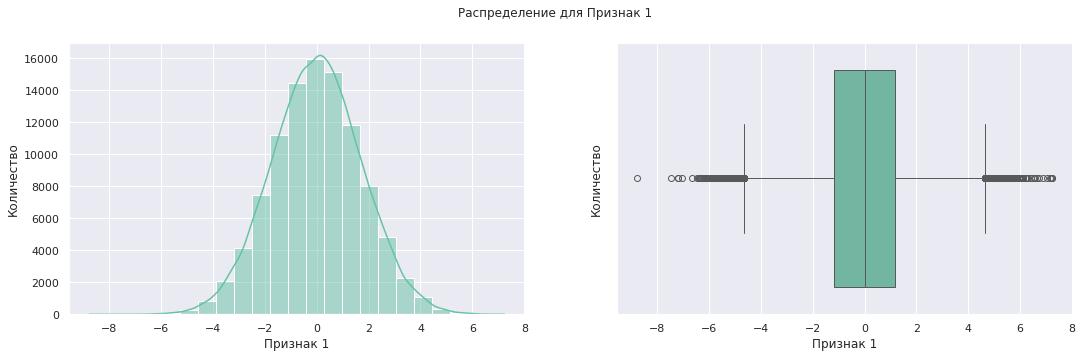

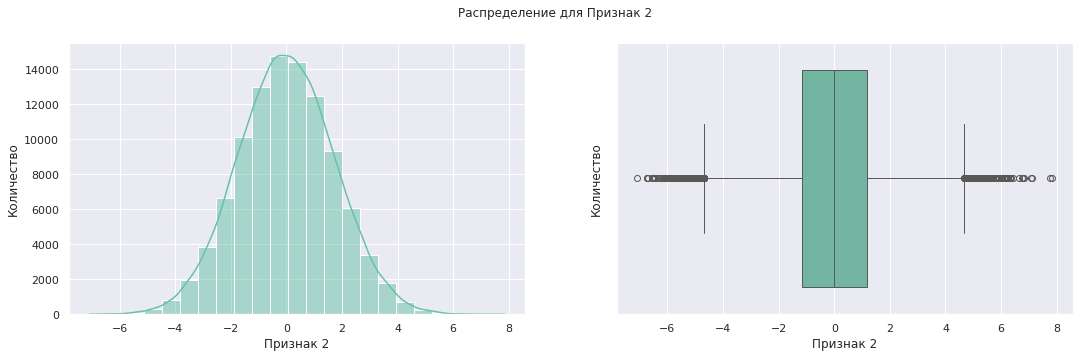

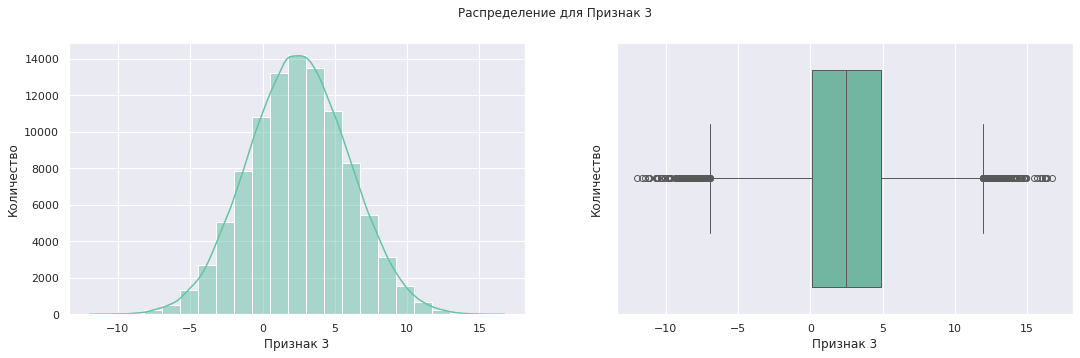

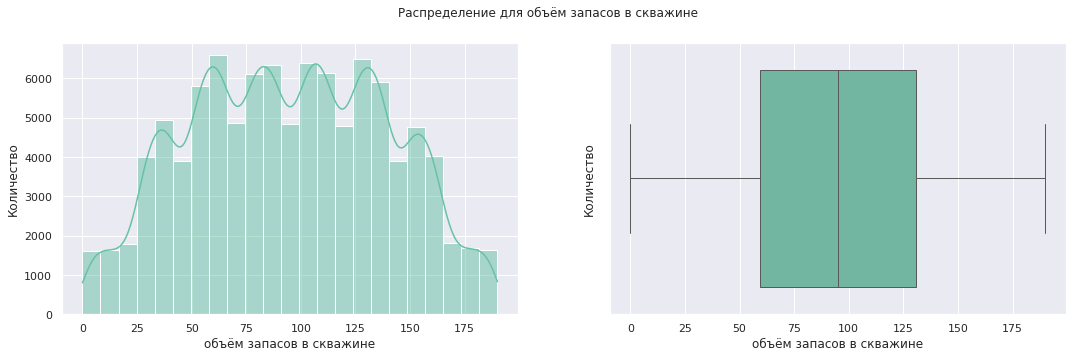

In [46]:
numerical_plot(region_geo_2, 'для третьего региона', numerical_features)

Для третьего региона не наблюдается каких-то аномальных распределений или выбросов, три признака распределены нормально, однако у объема запасов в скважине нет четкого максимума и распределение нельзя назвать нормальным

**Вывод:** 
- В зависимости от региона, распределение признаков очень сильно меняется. На графиках присутствует как нормальное распределение, так и графики с аномальными выбросами.

### Проведем корреляционный анализ признаков

In [47]:
def corr_matrix(list_data, df_name: str) -> None:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for num, data in enumerate(list_data):
        sns.heatmap(data.drop(columns='id').corr(method='spearman', numeric_only=True), 
                    annot=True, 
                    cmap='seismic', 
                    fmt=".2f",
                    ax=axes[num]
                    )
        axes[num].set_title(f'для датафрейма {df_name[num]}')
    fig.suptitle(f'Матрица корреляции количественных признаков по методу Спирмена')

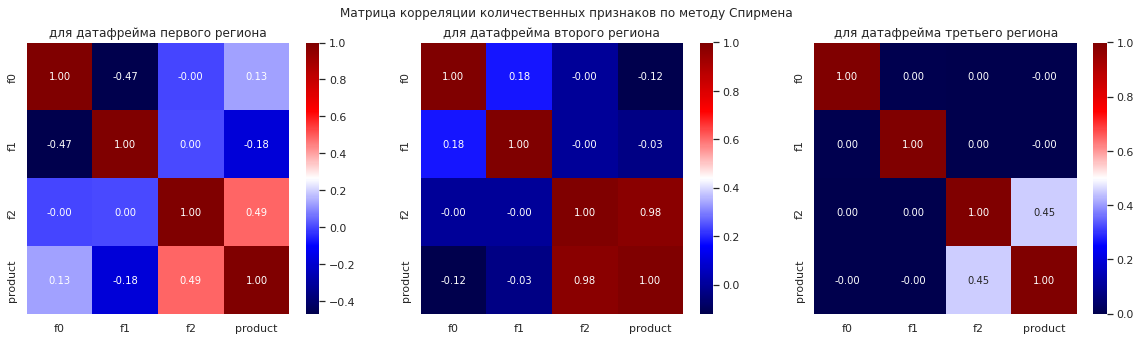

In [48]:

corr_matrix([region_geo_0, region_geo_1, region_geo_2], ['первого региона', 'второго региона', 'третьего региона'])


**Вывод:**
- Для датасета второго региона обнаружена очень высокая корреляционная связь между признаком `f2` и `product` - практически равная 1. Признаки `f0` и `f1` оказывает слабое отрицательное и отсутствие влияние соответственно.
- Для датасетов первого и третьего региона для признака `f2` наблюдается умеренная корреляция с таргетом, однако для третьего региона также наблюдается отстутствие корреляции между `f0`, `f1` и `product`, тогда как для первого региона наблюдается слабая положительная и слабая отрицательная связь для признаков `f0` и `f1` соответственно.

**Итоговый вывод по блоку:**
- Были проанализированны датасеты с данными: для каждого региона представлены данные о трех входных признаках и таргете - объеме продукта в баррелях. Среди записей таблицы были обнаружены дубликаты по уникальным идентификаторам скважин, были принято решение удалить эти данные. Всего было удалено 18 записей. Среди данных полных дубликатов или пропусков не было обнаружено.
- Для всех трех регионов были построены графики распределения количественных признаков:
    - В зависимости от региона, распределение признаков очень сильно меняется. На графиках присутствует как нормальное распределение, так и графики с аномальными выбросами, крайне аномальные распределения для второго региона.
- Была построена матрица корреляции для каждого региона:
    - Для датасета второго региона обнаружена очень высокая корреляционная связь между признаком `f2` и `product` - практически равная 1.
    - Для датасетов первого и третьего региона для признака `f2` наблюдается умеренная корреляция с таргетом

## Обучение и проверка модели

1. Данные делятся на обучающую и валидационную выборки в соотношении 75:25.
2. Обучается модель и делаются предсказания на валидационной выборке.
3. Предсказания и правильные ответы на валидационной выборке сохраняются.
4. Средний запас предсказанного сырья и _RMSE_ модели выводятся на экран.
5. Анализируются результаты.

In [49]:
preprocessor = Pipeline([('first_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                         ('scaler', StandardScaler()),
                         ('last_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

full_pipeline = Pipeline([('preprocessor', preprocessor),
                          ('model', LinearRegression())])

In [50]:
params_grid = [
    {
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False],
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': np.logspace(-4, 1, 6),
        'model__fit_intercept': [True, False],
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': np.logspace(-4, 1, 6),
        'model__fit_intercept': [True, False],
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    },
    {
        'model': [ElasticNet(random_state=RANDOM_STATE)],
        'model__alpha': np.logspace(-4, 1, 6),
        'model__l1_ratio': np.linspace(0.1, 0.9, 9),
        'model__fit_intercept': [True, False],
        'preprocessor__scaler': [MinMaxScaler(), RobustScaler(), StandardScaler(), 'passthrough']
    }
]

In [51]:
def create_model(X: pd.DataFrame, y: pd.Series, pipeline: Pipeline, params: list, scoring: str = 'neg_mean_squared_error') -> Pipeline:
    reg_search = RandomizedSearchCV(pipeline,
                                  params_grid,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  random_state=RANDOM_STATE,
                                  n_iter=10,
                                  error_score='raise')
    
    reg_search.fit(X, y)
    return reg_search

In [52]:
def fit_model(data: pd.DataFrame, pipeline: Pipeline, params: list):
    X_reg = data.set_index('id').drop(columns='product')
    y_reg = data.set_index('id')['product']

    X_train, X_valid, y_train, y_valid = train_test_split(X_reg,
                                                          y_reg,
                                                          test_size=0.25,
                                                          random_state=RANDOM_STATE)
    
    reg_search = create_model(X_train, y_train, pipeline, params)
    predictions = reg_search.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    
    return rmse, predictions, y_valid, reg_search


**Модель для первого региона**

In [53]:
rmse_reg_0, predictions_reg_0, true_label_reg_0, pipeline_reg_0 = fit_model(region_geo_0, full_pipeline, params_grid)
metrics = {'reg_0': {"rmse": rmse_reg_0, 
                     "mean_predictions": predictions_reg_0.mean(), 
                     'mean_true': true_label_reg_0.mean()}}
values_for_all = {'reg_0': {'true': true_label_reg_0.reset_index(drop=True),
                            'pred': predictions_reg_0}}

In [54]:
pd.DataFrame(pipeline_reg_0.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__scaler,param_model__l1_ratio,param_model__fit_intercept,param_model__alpha,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.184312,0.029874,0.044809,0.051910,passthrough,0.2,True,0.0001,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': 'passthrough', 'model...",-1401.101170,-1407.636544,-1426.264573,-1439.570452,-1432.920652,-1421.498678,14.751145,1
9,0.137611,0.041729,0.014057,0.015752,MinMaxScaler(),NaN,True,0.0001,Ridge(random_state=5),"{'preprocessor__scaler': MinMaxScaler(), 'mode...",-1401.099498,-1407.637988,-1426.264172,-1439.569268,-1432.922575,-1421.498700,14.751318,2
1,0.203200,0.027895,0.044391,0.059847,StandardScaler(),0.9,True,0.01,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': StandardScaler(), 'mo...",-1401.061927,-1407.644934,-1426.303964,-1439.573542,-1432.914426,-1421.499759,14.762776,3
0,0.148636,0.050367,0.064696,0.052886,MinMaxScaler(),0.4,True,0.0001,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-1400.984798,-1407.668783,-1426.372721,-1439.612357,-1432.909983,-1421.509729,14.793000,4
8,0.303593,0.001355,0.063339,0.044681,MinMaxScaler(),0.1,False,0.0001,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-1413.375482,-1407.486341,-1426.173657,-1440.676572,-1432.995015,-1424.141413,12.241115,5


In [55]:
pipeline_reg_0.best_params_

{'preprocessor__scaler': 'passthrough',
 'model__l1_ratio': 0.2,
 'model__fit_intercept': True,
 'model__alpha': 0.0001,
 'model': ElasticNet(alpha=0.0001, l1_ratio=0.2, random_state=5)}

In [56]:
metrics['reg_0']

{'rmse': 37.669543516164985,
 'mean_predictions': 92.34093614569504,
 'mean_true': 92.22912217437192}

**Модель для второго региона**

In [57]:
rmse_reg_1, predictions_reg_1, true_label_reg_1, pipeline_reg_1 = fit_model(region_geo_1, full_pipeline, params_grid)
metrics['reg_1'] = {"rmse": rmse_reg_1, 
                    "mean_predictions": predictions_reg_1.mean(), 
                    'mean_true': true_label_reg_1.mean()}

values_for_all['reg_1'] = {'true': true_label_reg_1.reset_index(drop=True),
                           'pred': predictions_reg_1}

In [58]:
pd.DataFrame(pipeline_reg_1.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__scaler,param_model__l1_ratio,param_model__fit_intercept,param_model__alpha,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.150180,0.005697,0.011484,0.010408,MinMaxScaler(),NaN,True,0.0001,"Ridge(alpha=0.0001, random_state=5)","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-0.799596,-0.780697,-0.790491,-0.810547,-0.788696,-0.794005,0.010223,1
7,0.149097,0.028736,0.071559,0.066663,passthrough,0.2,True,0.0001,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': 'passthrough', 'model...",-0.799578,-0.780706,-0.790513,-0.810541,-0.788697,-0.794007,0.010215,2
0,0.142281,0.032552,0.045485,0.035982,MinMaxScaler(),0.4,True,0.0001,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-0.799828,-0.781399,-0.791457,-0.811015,-0.789333,-0.794606,0.010086,3
1,0.192683,0.040674,0.065141,0.008510,StandardScaler(),0.9,True,0.01,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': StandardScaler(), 'mo...",-0.801773,-0.783960,-0.794508,-0.813495,-0.792098,-0.797167,0.009950,4
8,0.334453,0.047978,0.066075,0.043851,MinMaxScaler(),0.1,False,0.0001,"ElasticNet(alpha=0.0001, l1_ratio=0.2, random_...","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-2.132222,-2.124179,-2.145571,-2.077174,-2.146692,-2.125168,0.025431,5


In [59]:
pipeline_reg_1.best_params_

{'preprocessor__scaler': MinMaxScaler(),
 'model__fit_intercept': True,
 'model__alpha': 0.0001,
 'model': Ridge(alpha=0.0001, random_state=5)}

In [60]:
metrics['reg_1']

{'rmse': 0.8884333549762944,
 'mean_predictions': 68.85479389979118,
 'mean_true': 68.85200925086139}

**Модель для третьего региона**

In [61]:
rmse_reg_2, predictions_reg_2, true_label_reg_2, pipeline_reg_2 = fit_model(region_geo_2, full_pipeline, params_grid)
metrics['reg_2'] = {"rmse": rmse_reg_2, 
                    "mean_predictions": predictions_reg_2.mean(), 
                    'mean_true': true_label_reg_2.mean()}

values_for_all['reg_2'] = {'true': true_label_reg_2.reset_index(drop=True),
                           'pred': predictions_reg_2}

In [62]:
pd.DataFrame(pipeline_reg_2.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__scaler,param_model__l1_ratio,param_model__fit_intercept,param_model__alpha,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.183146,0.040167,0.155623,0.043215,StandardScaler(),0.9,True,0.01,"ElasticNet(alpha=0.01, l1_ratio=0.9, random_st...","{'preprocessor__scaler': StandardScaler(), 'mo...",-1586.743738,-1616.496433,-1602.901453,-1598.066580,-1589.102618,-1598.662164,10.675404,1
7,0.152287,0.029235,0.107783,0.055855,passthrough,0.2,True,0.0001,"ElasticNet(alpha=0.01, l1_ratio=0.9, random_st...","{'preprocessor__scaler': 'passthrough', 'model...",-1586.753307,-1616.504758,-1602.914534,-1598.079583,-1589.070306,-1598.664498,10.682741,2
9,0.155268,0.005008,0.006424,0.000312,MinMaxScaler(),NaN,True,0.0001,"Ridge(alpha=0.0001, random_state=5)","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-1586.753350,-1616.504796,-1602.914597,-1598.079604,-1589.070179,-1598.664505,10.682772,3
0,0.130351,0.051532,0.126681,0.049176,MinMaxScaler(),0.4,True,0.0001,"ElasticNet(alpha=0.01, l1_ratio=0.9, random_st...","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-1586.738114,-1616.491507,-1602.887005,-1598.088410,-1589.144558,-1598.669919,10.666128,4
8,0.341177,0.047899,0.082248,0.069295,MinMaxScaler(),0.1,False,0.0001,"ElasticNet(alpha=0.01, l1_ratio=0.9, random_st...","{'preprocessor__scaler': MinMaxScaler(), 'mode...",-1589.624352,-1619.789800,-1606.232350,-1599.543061,-1594.952528,-1602.028418,10.423491,5


In [63]:
pipeline_reg_2.best_params_

{'preprocessor__scaler': StandardScaler(),
 'model__l1_ratio': 0.9,
 'model__fit_intercept': True,
 'model__alpha': 0.01,
 'model': ElasticNet(alpha=0.01, l1_ratio=0.9, random_state=5)}

In [64]:
metrics['reg_2']

{'rmse': 40.27810298175063,
 'mean_predictions': 95.02417147034583,
 'mean_true': 95.08866941281924}

**Вывод**:
- В качестве улучшения кода и гибкости подбора параметров для модели был реализован пайплайн и функции для обучения моделей. 
- В качестве моделей выступали: `LinearRegression`, `Lasso`, `Ridge`, `ElasticNet`, которые удовлетворяют условиям задачи "Использование линейной модели"
- Пользуясь парадигмой DRY была реализована функция обучения моделей для каждого региона.
- Для первого региона:
    - Лучшая модель: `ElasticNet(alpha=0.0001, l1_ratio=0.2, random_state=5)`
    - Значение RMSE на валидационной выборке: 37.7
    - Средний запас предсказанного сырья: 92.34 тыс.
    - Средний запас реального сырья: 92.23 тыс.
- Для второго региона:
    - Лучшая модель: `Ridge(alpha=0.0001, random_state=5)`
    - Значение RMSE на валидационной выборке: 0.88
    - Средний запас предсказанного сырья: 68.85 тыс.
    - Средний запас реального сырья: 68.85 тыс.
- Для третьего региона:
    - Лучшая модель: `ElasticNet(alpha=0.01, l1_ratio=0.9, random_state=5)`
    - Значение RMSE на валидационной выборке: 40.27
    - Средний запас предсказанного сырья: 95.02 тыс.
    - Средний запас реального сырья: 95.09 тыс.

## Подготовка к расчёту прибыли

1. Все ключевые значения для расчетов сохраняются в отдельных переменных.
2. Рассчитывается достаточный объем сырья для безубыточной разработки новой скважины и сравнивается со средним запасом в каждом регионе.
3. Пишутся выводы по этапу подготовки расчёта прибыли.

In [65]:
# 500 точек и 200 лучших
NUMBER = 500  
BEST = 200    
# Затраты на разработку
BUDGET = 10 ** 7 
# Доход 
COST_1_BARREL = 450 
# Количество выборок
NUM_CIRCLE_BOOSTRAP = 1000 

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [66]:
print("Точка неубыточности: больше, чем {0:.0f} тыс. баррелей на каждый регион.\n". \
      format(BUDGET / COST_1_BARREL))
print("Средний объем нефти в скважине, для неубыточной работы: больше, чем {0:.0f} тыс. баррелей.". \
      format(BUDGET / COST_1_BARREL /BEST))

Точка неубыточности: больше, чем 22222 тыс. баррелей на каждый регион.

Средний объем нефти в скважине, для неубыточной работы: больше, чем 111 тыс. баррелей.


Проверим какие объемы нефти предсказаны моделями и действительно существуют.

In [67]:
for keys, values in metrics.items():
    print(f'Для региона {keys}')
    if values['mean_predictions'] < 111:
        print(f'Предсказанные значения меньше, чем необходимые для окупаемости, {round(values["mean_predictions"], 2)} тыс. < 111 тыс.')
    else:
        print(f'Предсказанные значения больше, чем необходимые, разработка окупится, {round(values["mean_predictions"], 2)} тыс. > 111 тыс.')

    if values['mean_true'] < 111:
        print(f'Реальные значения меньше, чем необходимые для окупаемости, {round(values["mean_true"], 2)} тыс. < 111 тыс.')
    else:
        print(f'Реальные значения больше, чем необходимые, разработка окупится, {round(values["mean_true"], 2)} тыс. > 111 тыс.')
    print()

Для региона reg_0
Предсказанные значения меньше, чем необходимые для окупаемости, 92.34 тыс. < 111 тыс.
Реальные значения меньше, чем необходимые для окупаемости, 92.23 тыс. < 111 тыс.

Для региона reg_1
Предсказанные значения меньше, чем необходимые для окупаемости, 68.85 тыс. < 111 тыс.
Реальные значения меньше, чем необходимые для окупаемости, 68.85 тыс. < 111 тыс.

Для региона reg_2
Предсказанные значения меньше, чем необходимые для окупаемости, 95.02 тыс. < 111 тыс.
Реальные значения меньше, чем необходимые для окупаемости, 95.09 тыс. < 111 тыс.



**Вывод**:
- Поскольку все средний объём запасов в скважине (тыс. барреле) для всех скважин в каждом регионе меньше, чем необходимый для окупаемости объем, необходимо провести анализ точек и выбрать из них 200 лучших для разработки.

In [68]:
def calc_profit(target, predictions):
    predictions_sorted = pd.Series(predictions).sort_values(ascending=False)
    top_indices = predictions_sorted.index[:BEST] 
    target_selected = target.iloc[top_indices]

    return (target_selected.sum() * COST_1_BARREL - BUDGET)

In [69]:
profit_regions = pd.DataFrame(columns=['Регион', 'Прибыль (в млрд.)'])
for keys, values in values_for_all.items():
    profit_regions.loc[len(profit_regions)] = keys, round(calc_profit(values['true'], values['pred']) / 10**6, 2)

profit_regions

,Регион,Прибыль (в млрд.)
0,reg_0,3.24
1,reg_1,2.42
2,reg_2,2.33


**Вывод**:
- Все три региона прибыльные, если выбрать наиболее выгодные точки месторождений для разработки

## Расчёт прибыли и рисков 

1. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели:
   - Выбираются скважины с максимальными предсказаниями.
   - Суммируется целевое значение объёма сырья, соответствующее этим предсказаниям.
   - Рассчитывается прибыль для полученного объёма сырья.

2. Риски и прибыль для каждого региона:
   - Применяется _Bootstrap_ с 1000 выборок для нахождения распределения прибыли.
   - Вычисляются средняя прибыль, 95%-й доверительный интервал и риск убытков. Убыток — отрицательная прибыль.
   - Пишутся выводы с предложением региона для разработки скважин и обоснованием этого выбора.

In [70]:
df_result = pd.DataFrame(columns=['Регион', 
                                  'Средняя прибыль, млн', 
                                  'Левая граница 95% дов. инт., млн', 
                                  'Правая граница 95% дов. инт., млн', 
                                  'Риски, %'])

names_reg = ['1 регион', '2 регион', '3 регион']

for num, (key, value) in enumerate(values_for_all.items()):
    pred = value['pred']
    true_target = value['true']

    profit = []
    for _ in range(NUM_CIRCLE_BOOSTRAP):
        true_sample = true_target.sample(NUMBER, replace=True, random_state=STATE)
        pred_sample = pred[true_sample.index]

        true_sample.reset_index(drop=True, inplace=True)
        
        profit.append(calc_profit(true_sample, pred_sample))
        
    profit = pd.Series(profit)

    mean_profit = round(profit.mean() / 1000, 2)
    confidence_inteval_start = round(profit.quantile(0.025) / 1000, 2)
    confidence_inteval_end = round(profit.quantile(0.975) / 1000, 2)
    risk = (profit < 0).mean() * 100

    df_result.loc[len(df_result)] = names_reg[num], mean_profit, confidence_inteval_start, confidence_inteval_end, risk


<div class="alert alert-block alert-success">
<b>Успех:</b> С бутстрапом тоже все в порядке (сэмплирование происходит с возвращением), метрики считаются верным образом!  
</div>

In [71]:
df_result

,Регион,"Средняя прибыль, млн","Левая граница 95% дов. инт., млн","Правая граница 95% дов. инт., млн","Риски, %"
0,1 регион,400.75,-105.70,901.52,6.5
1,2 регион,469.89,63.91,897.94,1.0
2,3 регион,324.59,-204.97,870.05,10.7


Text(0.5, 1.0, 'Риски для каждого региона для 200 лучших точек')

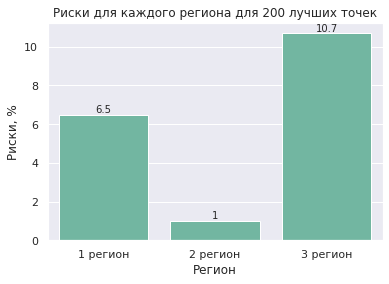

In [72]:
figure = sns.barplot(data=df_result, y='Риски, %', x='Регион')
figure.bar_label(figure.containers[0], fontsize=10);
figure.set_title('Риски для каждого региона для 200 лучших точек')

**Вывод**:
- Только для 2 региона вероятность убытков меньше 2,5%
- Средняя прибыль для второго региона составляет более 400 млн рублей
- Левая граница 95% доверительного интервала не содержит отрицательных значений, в отличие от двух других регионов

## Итоговый вывод по проекту:
- Были проанализированны датасеты с данными: для каждого региона представлены данные о трех входных признаках и таргете - объеме продукта в баррелях. Среди записей таблицы были обнаружены дубликаты по уникальным идентификаторам скважин, были принято решение удалить эти данные. Всего было удалено 18 записей. Среди данных полных дубликатов или пропусков не было обнаружено.
- Для всех трех регионов были построены графики распределения количественных признаков:
    - В зависимости от региона, распределение признаков очень сильно меняется. На графиках присутствует как нормальное распределение, так и графики с аномальными выбросами, крайне аномальные распределения для второго региона.
- Была построена матрица корреляции для каждого региона:
    - Для датасета второго региона обнаружена очень высокая корреляционная связь между признаком `f2` и `product` - практически равная 1.
    - Для датасетов первого и третьего региона для признака `f2` наблюдается умеренная корреляция с таргетом
    
- Было произведено обучение моделей для каждого региона, поскольку данные сильно различаются от региона к региону.
    - В качестве улучшения кода и гибкости подбора параметров для модели был реализован пайплайн и функции для обучения моделей. 
    - В качестве моделей выступали: `LinearRegression`, `Lasso`, `Ridge`, `ElasticNet`, которые удовлетворяют условиям задачи "Использование линейной модели"
    - Пользуясь парадигмой DRY была реализована функция обучения моделей для каждого региона.
    - Для первого региона:
        - Лучшая модель: `ElasticNet(alpha=0.0001, l1_ratio=0.2, random_state=5)`
        - Значение RMSE на валидационной выборке: 37.7
        - Средний запас предсказанного сырья: 92.34 тыс.
        - Средний запас реального сырья: 92.23 тыс.
    - Для второго региона:
        - Лучшая модель: `Ridge(alpha=0.0001, random_state=5)`
        - Значение RMSE на валидационной выборке: 0.88
        - Средний запас предсказанного сырья: 68.85 тыс.
        - Средний запас реального сырья: 68.85 тыс.
    - Для третьего региона:
        - Лучшая модель: `ElasticNet(alpha=0.01, l1_ratio=0.9, random_state=5)`
        - Значение RMSE на валидационной выборке: 40.27
        - Средний запас предсказанного сырья: 95.02 тыс.
        - Средний запас реального сырья: 95.09 тыс.
- Был произведен расчет прибыли, в результате которого было принято решение о прибыльности всех трех регионов, однако необходимо использовать не все 500 точек, а подобрать 200 лучших. В результате получены данные о предполагаемой прибыльности регионов:

In [73]:
profit_regions

,Регион,Прибыль (в млрд.)
0,reg_0,3.24
1,reg_1,2.42
2,reg_2,2.33


Где:
- `reg_0` - первый регион
- `reg_1` - второй регион
- `reg_2` - третий регион

- был произведен расчет прибыли и рисков с использованием Bootstrap, в результате которого минимальные риски были обнаружены только у второго региона (меньше 2,5 процентов)
- получены результаты о 95% доверительном интервале и средней прибыли с региона.

In [74]:
df_result

,Регион,"Средняя прибыль, млн","Левая граница 95% дов. инт., млн","Правая граница 95% дов. инт., млн","Риски, %"
0,1 регион,400.75,-105.70,901.52,6.5
1,2 регион,469.89,63.91,897.94,1.0
2,3 регион,324.59,-204.97,870.05,10.7


- На основании выполненного эксперимента и рассчетов предлагается использовать для разработки **второй регион**